# COMP3362 - AI Group Project

## Import Libraries

In [2]:
import numpy as np # linear algebra
import pandas as pd
import os
import re
import cv2
from matplotlib import pyplot as plt
from PIL import Image
from tqdm import tqdm
import torch

print("Pytorch: " + "GPU" if torch.cuda.is_available() else "CPU")

Pytorch: GPU


## Install Ultralytics YOLOv5 dependencies

In [2]:
!rm -rf ./yolov5 && git clone https://github.com/ultralytics/yolov5.git && cd ./yolov5/ && pip install -qr requirements.txt

Cloning into 'yolov5'...
remote: Enumerating objects: 15093, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 15093 (delta 0), reused 3 (delta 0), pack-reused 15088
Receiving objects: 100% (15093/15093), 13.68 MiB | 9.90 MiB/s, done.
Resolving deltas: 100% (10439/10439), done.


## Read CSV Data

In [3]:
train_df = pd.read_csv("./data/train.csv")
train_df

,video_id,sequence,video_frame,sequence_frame,image_id,annotations
0,0,40258,0,0,0-0,[]
1,0,40258,1,1,0-1,[]
2,0,40258,2,2,0-2,[]
3,0,40258,3,3,0-3,[]
4,0,40258,4,4,0-4,[]
...,...,...,...,...,...,...
23496,2,29859,10755,2983,2-10755,[]
23497,2,29859,10756,2984,2-10756,[]
23498,2,29859,10757,2985,2-10757,[]
23499,2,29859,10758,2986,2-10758,[]


### Pasrse and process data

In [4]:
parseLabels = re.compile(r"\{ ?'x' ?: ?\d+, ?'y' ?: ?\d+, ?'width' ?: ?\d+, ?'height' ?: ?\d+ ?\}")
no_brackets = re.compile(r"\[|\{|\}|\]")
to_numeric_array = lambda x: [[pd.to_numeric(i.split(":")[1].strip()) for i in  no_brackets.sub("", i).split(",")] for i in parseLabels.findall(x)]

In [5]:
# lambda function parses for workable data
## new column "labels_array" created holding the list of lists --> each label is as follows: [[x_min,y_min,w,h]]
## x_min, y_min points to upper left corner of boudning box
train_df["labels_array"] = train_df[train_df["annotations"] != '[]']["annotations"].apply(to_numeric_array)

## drop unnecsary column
train_df = train_df.drop(columns="annotations")

### Create column holding file path

In [6]:
# add column of filepaths.
train_df["path_from_id"] = train_df.apply(lambda x: os.path.join("./data/train_images", f"video_{x['video_id']}", f"{x['video_frame']}.jpg"), axis=1)

### Drop NA
Since ultralytics does not need files without labels

In [7]:
train = train_df[pd.notna(train_df["labels_array"])][["image_id", "labels_array", "path_from_id"]].reset_index(drop=True)
train

,image_id,labels_array,path_from_id
0,0-16,"[[559, 213, 50, 32]]",./data/train_images/video_0/16.jpg
1,0-17,"[[558, 213, 50, 32]]",./data/train_images/video_0/17.jpg
2,0-18,"[[557, 213, 50, 32]]",./data/train_images/video_0/18.jpg
3,0-19,"[[556, 214, 50, 32]]",./data/train_images/video_0/19.jpg
4,0-20,"[[555, 214, 50, 32]]",./data/train_images/video_0/20.jpg
...,...,...,...
4914,2-10628,"[[92, 532, 40, 37]]",./data/train_images/video_2/10628.jpg
4915,2-10629,"[[78, 569, 40, 37]]",./data/train_images/video_2/10629.jpg
4916,2-10630,"[[65, 606, 41, 37]]",./data/train_images/video_2/10630.jpg
4917,2-10631,"[[51, 643, 44, 37]]",./data/train_images/video_2/10631.jpg


## Split into test, train, and validation

In [8]:
test = train.sample(frac=0.1, axis=0)
train = train.drop(index=test.index)
test = test.reset_index(drop=True)
train = train.reset_index(drop=True)

In [9]:
train.head()

,image_id,labels_array,path_from_id
0,0-16,"[[559, 213, 50, 32]]",./data/train_images/video_0/16.jpg
1,0-17,"[[558, 213, 50, 32]]",./data/train_images/video_0/17.jpg
2,0-18,"[[557, 213, 50, 32]]",./data/train_images/video_0/18.jpg
3,0-19,"[[556, 214, 50, 32]]",./data/train_images/video_0/19.jpg
4,0-20,"[[555, 214, 50, 32]]",./data/train_images/video_0/20.jpg


In [10]:
test.head()

,image_id,labels_array,path_from_id
0,1-5294,"[[579, 424, 77, 73]]",./data/train_images/video_1/5294.jpg
1,0-67,"[[448, 72, 57, 57]]",./data/train_images/video_0/67.jpg
2,0-4800,"[[623, 109, 31, 20]]",./data/train_images/video_0/4800.jpg
3,0-250,"[[893, 280, 37, 35]]",./data/train_images/video_0/250.jpg
4,1-8901,"[[830, 348, 40, 40], [387, 580, 31, 37]]",./data/train_images/video_1/8901.jpg


## Build data and labels
Since data provided to us in unsuitable for use in YOLOv5, we will copy necessary data into our working repository.

### Reset working repository data
Delete any images and labels data currently present.

In [11]:
!rm -rf ./training && mkdir -p ./training/images/ ./training/labels/ 

### Copy images into working repository

In [12]:
import shutil
for i in train.index:
    shutil.copyfile(train.loc[i]["path_from_id"], os.path.join("./training","images", train.iloc[i]["image_id"]+".jpg"))

    

### Nromalize Boundaries
Bring bpunding box parameters to YoloV5 format


In [13]:
bring_to_center = lambda m: [[(x[0]+(x[2]/2))/1280, (x[1]+(x[3]/2))/720, x[2]/1280, x[3]/720] for x in m] 

train["labels_array"] = train["labels_array"].apply(bring_to_center)

### Write annotations to train_labels

In [14]:
def printLabels(df):
    for i in df.index:
        with open(os.path.join("./training","labels",df["image_id"].iloc[i]+".txt"), "w") as outfile:
            for arr in df["labels_array"].iloc[i]:
                outfile.write(f"0 {arr[0]} {arr[1]} {arr[2]} {arr[3]}\n")
            outfile.close()

printLabels(train)

## Train model

In [15]:
# training for 50 epochs
!cd ./yolov5 && python train.py --img 704 --batch 16 --epochs 50 --data ../files/data.yaml --weights yolov5s.pt --device 0

train: weights=yolov5s.pt, cfg=, data=../files/data.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=50, batch_size=16, imgsz=704, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=0, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=exp, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v6.2-249-gff6e6e3 Python-3.8.15 torch-1.7.1 CUDA:0 (NVIDIA GeForce GTX 1080 Ti, 11178MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl_gamma=0.0, hsv_h=0.015, hsv

                 Class     Images  Instances          P          R      mAP50   
                   all       4426      10661      0.833       0.68      0.783      0.375

      Epoch    GPU_mem   box_loss   obj_loss   cls_loss  Instances       Size
       7/49      5.42G    0.04378    0.01807          0         47        704: 1
                 Class     Images  Instances          P          R      mAP50   
                   all       4426      10661      0.903      0.806      0.894      0.456

      Epoch    GPU_mem   box_loss   obj_loss   cls_loss  Instances       Size
       8/49      5.42G    0.04217    0.01717          0         70        704: 1
                 Class     Images  Instances          P          R      mAP50   
                   all       4426      10661      0.928      0.846      0.926      0.473

      Epoch    GPU_mem   box_loss   obj_loss   cls_loss  Instances       Size
       9/49      5.42G    0.04083     0.0166          0         33        704: 1
          

      31/49      5.42G    0.02936    0.01192          0         41        704: 1
                 Class     Images  Instances          P          R      mAP50   
                   all       4426      10661      0.973      0.969       0.99      0.655

      Epoch    GPU_mem   box_loss   obj_loss   cls_loss  Instances       Size
      32/49      5.42G    0.02887    0.01141          0         48        704: 1
                 Class     Images  Instances          P          R      mAP50   
                   all       4426      10661      0.972      0.976       0.99      0.661

      Epoch    GPU_mem   box_loss   obj_loss   cls_loss  Instances       Size
      33/49      5.42G    0.02901    0.01179          0         49        704: 1
                 Class     Images  Instances          P          R      mAP50   
                   all       4426      10661      0.973      0.972      0.989       0.66

      Epoch    GPU_mem   box_loss   obj_loss   cls_loss  Instances       Size
      34/4

In [16]:
# !rm -rf modelSaves/ && mkdir modelSaves/ && cp ./yolov5/runs/train/exp/weights/best.pt ./modelSaves/best.pt && cp ./yolov5/runs/train/exp/weights/last.pt ./modelSaves/last.pt

## Load model and visualize result

In [3]:
model = torch.hub.load("./yolov5", "custom", source='local', path="./modelSaves/best.pt", force_reload=True)

YOLOv5 🚀 v6.2-249-gff6e6e3 Python-3.8.15 torch-1.7.1 CUDA:0 (NVIDIA GeForce GTX 1080 Ti, 11178MiB)

Fusing layers... 
Model summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 


In [4]:
result = model("./data/train_images/video_1/628.jpg")
result.xyxy[0]

tensor([[576.25006, 485.13690, 817.40228, 710.20245,   0.97047,   0.00000]], device='cuda:0')

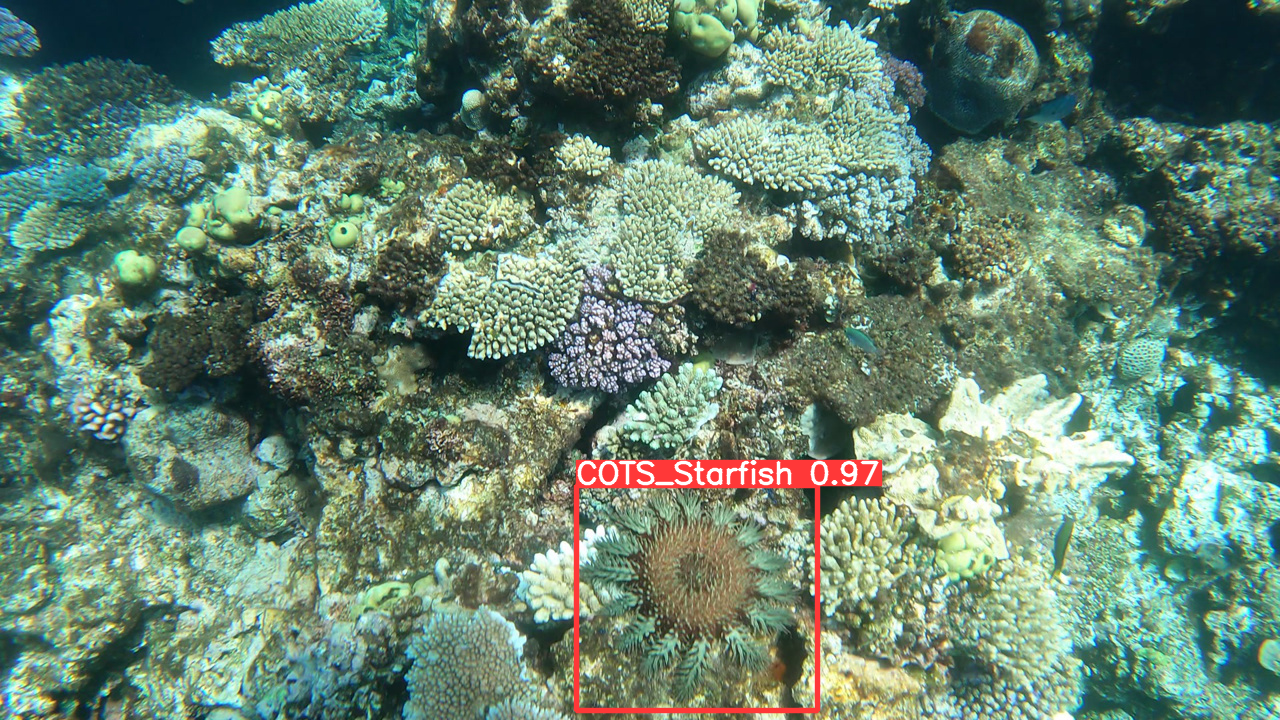

Saved 1 image to files2


In [5]:
result.show()
result.save(save_dir="./files")

## Calculating MSE of _number_ of starfishes identified

In [20]:
test.head()

,image_id,labels_array,path_from_id
0,1-5294,"[[579, 424, 77, 73]]",./data/train_images/video_1/5294.jpg
1,0-67,"[[448, 72, 57, 57]]",./data/train_images/video_0/67.jpg
2,0-4800,"[[623, 109, 31, 20]]",./data/train_images/video_0/4800.jpg
3,0-250,"[[893, 280, 37, 35]]",./data/train_images/video_0/250.jpg
4,1-8901,"[[830, 348, 40, 40], [387, 580, 31, 37]]",./data/train_images/video_1/8901.jpg


In [21]:
mse = []
for i in test.index[:30]:
    result = model(test.iloc[i]["path_from_id"])
    mse.append(result.xyxy[0].shape[0]-len(test.iloc[i]["labels_array"]))
mse_ = np.array(mse).reshape(-1,)
mse_ = np.sum(np.square(mse_))/mse_.shape[0]
print(f"MSE of number of starfishes identified: {mse_}")

MSE of number of starfishes identified: 0.13333333333333333


## Calculating MSE of _distance_ of starfishes centers

In [22]:
euclid = lambda l,m: (((l[0]+(l[2]/2))-m[0])**2 + ((l[1]+(l[3]/2))-m[1])**2)**0.5
def distance(arr_test, result):
    result = result.tolist()
    pairs_of_closest = []
    
    while ((len(arr_test)>0) and (len(result)>0)):
        d,x,y = None, None, None
        for i, arr_1 in enumerate(arr_test):
            for j, arr_2 in enumerate(result):
                euc = euclid(arr_1, arr_2)
                if ((d is None) or (euc < d)):
                    d = euc
                    x=i
                    y=j
        pairs_of_closest.append((arr_test.pop(x), result.pop(y), d/arr_1[2]))
    return pairs_of_closest

fmr = []
for arr, res in zip([arr for arr in test["labels_array"]],model([path for path in test["path_from_id"]]).xyxy):
    fmr.append(distance(arr[:], res.detach().clone()))
    

In [23]:
err_distance = []
for arr in fmr:
    for arr_ in arr:
        err_distance.append(arr_[-1])

tmp = np.array(err_distance).reshape(-1,)
print(f"MSE of stafish centers: {np.sum(np.square(tmp))/tmp.shape[0]}")

MSE of stafish centers: 0.8606648433562923


## Video Visualization Results

In [ ]:
tmp = pd.read_csv("./data/train.csv")
tmp["path"] = tmp[tmp["sequence"]==22643].apply(lambda x: os.path.join("./data/train_images", f"video_{x['video_id']}", f"{x['video_frame']}.jpg"), axis=1)
tmp = tmp[tmp["sequence"]==22643]

Create directory for output video

In [11]:
!rm -rf outputVideo/ && mkdir outputVideo/

Save labelled images from model results

In [17]:
for row in tmp["path"]:
    result = model(row)
    result.save()

Saved 1 image to runs/detect/exp
Saved 1 image to runs/detect/exp2
Saved 1 image to runs/detect/exp3
Saved 1 image to runs/detect/exp4
Saved 1 image to runs/detect/exp5
Saved 1 image to runs/detect/exp6
Saved 1 image to runs/detect/exp7
Saved 1 image to runs/detect/exp8
Saved 1 image to runs/detect/exp9
Saved 1 image to runs/detect/exp10
Saved 1 image to runs/detect/exp11
Saved 1 image to runs/detect/exp12
Saved 1 image to runs/detect/exp13
Saved 1 image to runs/detect/exp14
Saved 1 image to runs/detect/exp15
Saved 1 image to runs/detect/exp16
Saved 1 image to runs/detect/exp17
Saved 1 image to runs/detect/exp18
Saved 1 image to runs/detect/exp19
Saved 1 image to runs/detect/exp20
Saved 1 image to runs/detect/exp21
Saved 1 image to runs/detect/exp22
Saved 1 image to runs/detect/exp23
Saved 1 image to runs/detect/exp24
Saved 1 image to runs/detect/exp25
Saved 1 image to runs/detect/exp26
Saved 1 image to runs/detect/exp27
Saved 1 image to runs/detect/exp28
Saved 1 image to runs/detect/e

Saved 1 image to runs/detect/exp190
Saved 1 image to runs/detect/exp191
Saved 1 image to runs/detect/exp192
Saved 1 image to runs/detect/exp193
Saved 1 image to runs/detect/exp194
Saved 1 image to runs/detect/exp195
Saved 1 image to runs/detect/exp196
Saved 1 image to runs/detect/exp197
Saved 1 image to runs/detect/exp198
Saved 1 image to runs/detect/exp199
Saved 1 image to runs/detect/exp200
Saved 1 image to runs/detect/exp201
Saved 1 image to runs/detect/exp202
Saved 1 image to runs/detect/exp203
Saved 1 image to runs/detect/exp204
Saved 1 image to runs/detect/exp205
Saved 1 image to runs/detect/exp206
Saved 1 image to runs/detect/exp207
Saved 1 image to runs/detect/exp208
Saved 1 image to runs/detect/exp209
Saved 1 image to runs/detect/exp210
Saved 1 image to runs/detect/exp211
Saved 1 image to runs/detect/exp212
Saved 1 image to runs/detect/exp213
Saved 1 image to runs/detect/exp214
Saved 1 image to runs/detect/exp215
Saved 1 image to runs/detect/exp216
Saved 1 image to runs/detect

Saved 1 image to runs/detect/exp377
Saved 1 image to runs/detect/exp378
Saved 1 image to runs/detect/exp379
Saved 1 image to runs/detect/exp380
Saved 1 image to runs/detect/exp381
Saved 1 image to runs/detect/exp382
Saved 1 image to runs/detect/exp383
Saved 1 image to runs/detect/exp384
Saved 1 image to runs/detect/exp385
Saved 1 image to runs/detect/exp386
Saved 1 image to runs/detect/exp387
Saved 1 image to runs/detect/exp388
Saved 1 image to runs/detect/exp389
Saved 1 image to runs/detect/exp390
Saved 1 image to runs/detect/exp391
Saved 1 image to runs/detect/exp392
Saved 1 image to runs/detect/exp393
Saved 1 image to runs/detect/exp394
Saved 1 image to runs/detect/exp395
Saved 1 image to runs/detect/exp396
Saved 1 image to runs/detect/exp397
Saved 1 image to runs/detect/exp398
Saved 1 image to runs/detect/exp399
Saved 1 image to runs/detect/exp400
Saved 1 image to runs/detect/exp401
Saved 1 image to runs/detect/exp402
Saved 1 image to runs/detect/exp403
Saved 1 image to runs/detect

Saved 1 image to runs/detect/exp564
Saved 1 image to runs/detect/exp565
Saved 1 image to runs/detect/exp566
Saved 1 image to runs/detect/exp567
Saved 1 image to runs/detect/exp568
Saved 1 image to runs/detect/exp569
Saved 1 image to runs/detect/exp570
Saved 1 image to runs/detect/exp571
Saved 1 image to runs/detect/exp572
Saved 1 image to runs/detect/exp573
Saved 1 image to runs/detect/exp574
Saved 1 image to runs/detect/exp575
Saved 1 image to runs/detect/exp576
Saved 1 image to runs/detect/exp577
Saved 1 image to runs/detect/exp578
Saved 1 image to runs/detect/exp579
Saved 1 image to runs/detect/exp580
Saved 1 image to runs/detect/exp581
Saved 1 image to runs/detect/exp582
Saved 1 image to runs/detect/exp583
Saved 1 image to runs/detect/exp584
Saved 1 image to runs/detect/exp585
Saved 1 image to runs/detect/exp586
Saved 1 image to runs/detect/exp587
Saved 1 image to runs/detect/exp588
Saved 1 image to runs/detect/exp589
Saved 1 image to runs/detect/exp590
Saved 1 image to runs/detect

Saved 1 image to runs/detect/exp751
Saved 1 image to runs/detect/exp752
Saved 1 image to runs/detect/exp753
Saved 1 image to runs/detect/exp754
Saved 1 image to runs/detect/exp755
Saved 1 image to runs/detect/exp756
Saved 1 image to runs/detect/exp757
Saved 1 image to runs/detect/exp758
Saved 1 image to runs/detect/exp759
Saved 1 image to runs/detect/exp760
Saved 1 image to runs/detect/exp761
Saved 1 image to runs/detect/exp762
Saved 1 image to runs/detect/exp763
Saved 1 image to runs/detect/exp764
Saved 1 image to runs/detect/exp765
Saved 1 image to runs/detect/exp766
Saved 1 image to runs/detect/exp767
Saved 1 image to runs/detect/exp768
Saved 1 image to runs/detect/exp769
Saved 1 image to runs/detect/exp770
Saved 1 image to runs/detect/exp771
Saved 1 image to runs/detect/exp772
Saved 1 image to runs/detect/exp773
Saved 1 image to runs/detect/exp774
Saved 1 image to runs/detect/exp775
Saved 1 image to runs/detect/exp776
Saved 1 image to runs/detect/exp777
Saved 1 image to runs/detect

Saved 1 image to runs/detect/exp938
Saved 1 image to runs/detect/exp939
Saved 1 image to runs/detect/exp940
Saved 1 image to runs/detect/exp941
Saved 1 image to runs/detect/exp942
Saved 1 image to runs/detect/exp943
Saved 1 image to runs/detect/exp944
Saved 1 image to runs/detect/exp945
Saved 1 image to runs/detect/exp946
Saved 1 image to runs/detect/exp947
Saved 1 image to runs/detect/exp948
Saved 1 image to runs/detect/exp949
Saved 1 image to runs/detect/exp950
Saved 1 image to runs/detect/exp951
Saved 1 image to runs/detect/exp952
Saved 1 image to runs/detect/exp953
Saved 1 image to runs/detect/exp954
Saved 1 image to runs/detect/exp955
Saved 1 image to runs/detect/exp956
Saved 1 image to runs/detect/exp957
Saved 1 image to runs/detect/exp958
Saved 1 image to runs/detect/exp959
Saved 1 image to runs/detect/exp960
Saved 1 image to runs/detect/exp961
Saved 1 image to runs/detect/exp962
Saved 1 image to runs/detect/exp963
Saved 1 image to runs/detect/exp964
Saved 1 image to runs/detect

Saved 1 image to runs/detect/exp1122
Saved 1 image to runs/detect/exp1123
Saved 1 image to runs/detect/exp1124
Saved 1 image to runs/detect/exp1125
Saved 1 image to runs/detect/exp1126
Saved 1 image to runs/detect/exp1127
Saved 1 image to runs/detect/exp1128
Saved 1 image to runs/detect/exp1129
Saved 1 image to runs/detect/exp1130
Saved 1 image to runs/detect/exp1131
Saved 1 image to runs/detect/exp1132
Saved 1 image to runs/detect/exp1133
Saved 1 image to runs/detect/exp1134
Saved 1 image to runs/detect/exp1135
Saved 1 image to runs/detect/exp1136
Saved 1 image to runs/detect/exp1137
Saved 1 image to runs/detect/exp1138
Saved 1 image to runs/detect/exp1139
Saved 1 image to runs/detect/exp1140
Saved 1 image to runs/detect/exp1141
Saved 1 image to runs/detect/exp1142
Saved 1 image to runs/detect/exp1143
Saved 1 image to runs/detect/exp1144
Saved 1 image to runs/detect/exp1145
Saved 1 image to runs/detect/exp1146
Saved 1 image to runs/detect/exp1147
Saved 1 image to runs/detect/exp1148
S

Move files to one location and remove unnecessary directories

In [18]:
!cd runs/detect/ && find -type f | xargs -I% mv % . && find -mindepth 1 -type d | xargs -I% rm -rf %

Stitch video frames together

In [19]:
!cd runs/detect/ && ffmpeg -framerate 15 -start_number 5363 -i %d.jpg -c:v libx264 -r 15 -pix_fmt yuv420p ../../outputVideo/output.mp4

ffmpeg version 9c33b2f Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 9.3.0 (crosstool-NG 1.24.0.133_b0863d8_dirty)
  configuration: --prefix=/userhome/30/ubcasim/anaconda3/envs/hku --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1627813612080/_build_env/bin/x86_64-conda-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-gpl --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-libx264 --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame --pkg-config=/home/conda/feedstock_root/build_artifacts/ffmpeg_1627813612080/_build_env/bin/pkg-config
  libavutil      56. 51.100 / 56. 51.100
  libavcodec     58. 91.100 / 58. 91.100
  libavformat    58. 45.100 / 58. 45.100
  libavdevice    58. 10.100 / 58. 10.100
  libavfilter     7. 85.100 /  7. 85.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  7.100 /  5.  7.100
  libswresample   3. 

Delete images to save space

In [21]:
!rm -rf runs/